1. Import necessary library
2. Data collecting
    * District code collection
    * Combine 5 years csv data to one dataframe
3. Data Cleansing
4. Data Analysis via data visualization
5. Findings on data visualization
6. Getting venue data via Foursquare API
7. K-Mean clusting modelling on different district

# Import necessary library

In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import requests
!pip install geocoder
import geocoder
!pip3 install folium
import folium
!pip3 install beautifulsoup4
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
!pip3 install seaborn 
import seaborn as sns
!pip install missingno
import missingno as msno
import numpy as np
from pylab import rcParams

## Import Data

In [2]:
data_2015 = pd.read_csv('./data/crime-incident-reports-2015.csv')
data_2016 = pd.read_csv('./data/crime-incident-reports-2016.csv')
data_2017 = pd.read_csv('./data/crime-incident-reports-2017.csv')
data_2018 = pd.read_csv('./data/crime-incident-reports-2018.csv')
district = pd.read_csv('./data/district.csv')

## Checking their shape and total row count

In [3]:
print('2015: ',data_2015.shape)
print('2016: ',data_2016.shape)
print('2017: ',data_2017.shape)
print('2018: ',data_2018.shape)
total_row = data_2015.shape[0] + data_2016.shape[0] + data_2017.shape[0] + data_2018.shape[0] 
print(total_row)

2015:  (53597, 17)
2016:  (99430, 17)
2017:  (101338, 17)
2018:  (98888, 17)
353253


## Concat 4 years data into one dataframe

In [4]:
data = pd.concat([data_2015,data_2016,data_2017,data_2018])
data.shape

(353253, 17)

In [5]:
data.head(5)

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,I192068249,2647,Other,THREATS TO DO BODILY HARM,B2,280,NaN,2015-08-28 10:20:00,2015,8,Friday,10,Part Two,WASHINGTON ST,42.330119,-71.084251,"(42.33011862, -71.08425106)"
1,I192061894,1106,Confidence Games,FRAUD - CREDIT CARD / ATM FRAUD,C11,356,NaN,2015-08-20 00:00:00,2015,8,Thursday,0,Part Two,CHARLES ST,42.300605,-71.061268,"(42.30060543, -71.06126785)"
2,I192038828,1107,Fraud,FRAUD - IMPERSONATION,A1,172,NaN,2015-11-02 12:24:00,2015,11,Monday,12,Part Two,ALBANY ST,42.334288,-71.072395,"(42.33428841, -71.07239518)"
3,I192008877,1107,Fraud,FRAUD - IMPERSONATION,E18,525,NaN,2015-07-31 10:00:00,2015,7,Friday,10,Part Two,WINGATE RD,42.237009,-71.129566,"(42.23700950, -71.12956606)"
4,I182090828,1102,Fraud,FRAUD - FALSE PRETENSE / SCHEME,D4,159,NaN,2015-12-01 12:00:00,2015,12,Tuesday,12,Part Two,UPTON ST,42.342432,-71.072258,"(42.34243222, -71.07225766)"


## Setting district to dictionary format

In [6]:
district = district.set_index("DISTRICT")
#district.head()

In [7]:
dict_district = district.to_dict()
dict_district = dict_district['DISTRICT_NAME']
dict_district

{'A1': 'DOWNTOWN',
 'A15': 'CHARLESTOWN',
 'A7': 'EAST BOSTON',
 'B2': 'BOXBURY',
 'B3': 'MATTAPAN',
 'C6': 'SOUTH BOSTON',
 'C11': 'DORCHESTER',
 'D4': 'SOUTH END',
 'D14': 'BRIGHTON',
 'E5': 'WEST BOXBURY',
 'E13': 'JAMAICA PLAIN',
 'E18': 'HYDE PARK'}

## Dropping rows if district is nan or external

In [8]:
data = data.drop(data[data.DISTRICT=='External'].index)
data = data[data.DISTRICT.notna()]
data.shape

(351426, 17)

In [9]:
data['DISTRICT'].unique()
#data['District_name'] = district_name
#data.head(15)

array(['B2', 'C11', 'A1', 'E18', 'D4', 'B3', 'C6', 'D14', 'A7', 'E5',
       'E13', 'A15'], dtype=object)

## Adding district name into data 

In [10]:
district_name=[]
for i in data['DISTRICT']:
    for j in dict_district:
        if (i ==j):
            district_name.append(dict_district[j])
    

In [11]:
data['District_name'] = district_name
data.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location,District_name
0,I192068249,2647,Other,THREATS TO DO BODILY HARM,B2,280,NaN,2015-08-28 10:20:00,2015,8,Friday,10,Part Two,WASHINGTON ST,42.330119,-71.084251,"(42.33011862, -71.08425106)",BOXBURY
1,I192061894,1106,Confidence Games,FRAUD - CREDIT CARD / ATM FRAUD,C11,356,NaN,2015-08-20 00:00:00,2015,8,Thursday,0,Part Two,CHARLES ST,42.300605,-71.061268,"(42.30060543, -71.06126785)",DORCHESTER
2,I192038828,1107,Fraud,FRAUD - IMPERSONATION,A1,172,NaN,2015-11-02 12:24:00,2015,11,Monday,12,Part Two,ALBANY ST,42.334288,-71.072395,"(42.33428841, -71.07239518)",DOWNTOWN
3,I192008877,1107,Fraud,FRAUD - IMPERSONATION,E18,525,NaN,2015-07-31 10:00:00,2015,7,Friday,10,Part Two,WINGATE RD,42.237009,-71.129566,"(42.23700950, -71.12956606)",HYDE PARK
4,I182090828,1102,Fraud,FRAUD - FALSE PRETENSE / SCHEME,D4,159,NaN,2015-12-01 12:00:00,2015,12,Tuesday,12,Part Two,UPTON ST,42.342432,-71.072258,"(42.34243222, -71.07225766)",SOUTH END


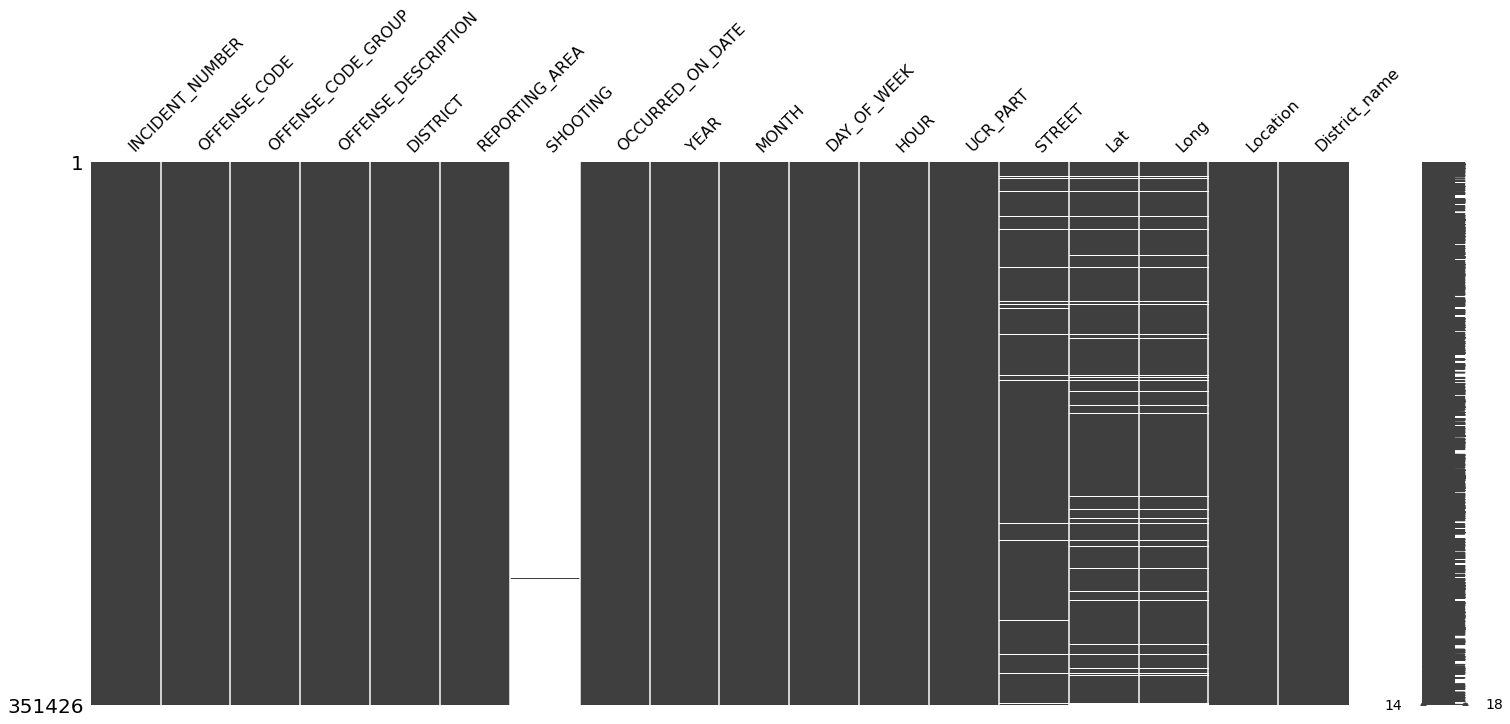

In [12]:
msno.matrix(data)
plt.show()

Since most of the cell from shooting columns are nan, this column will be deleted.

## Dropping shooting column

In [13]:
data = data.drop(columns='SHOOTING')
data.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location,District_name
0,I192068249,2647,Other,THREATS TO DO BODILY HARM,B2,280,2015-08-28 10:20:00,2015,8,Friday,10,Part Two,WASHINGTON ST,42.330119,-71.084251,"(42.33011862, -71.08425106)",BOXBURY
1,I192061894,1106,Confidence Games,FRAUD - CREDIT CARD / ATM FRAUD,C11,356,2015-08-20 00:00:00,2015,8,Thursday,0,Part Two,CHARLES ST,42.300605,-71.061268,"(42.30060543, -71.06126785)",DORCHESTER
2,I192038828,1107,Fraud,FRAUD - IMPERSONATION,A1,172,2015-11-02 12:24:00,2015,11,Monday,12,Part Two,ALBANY ST,42.334288,-71.072395,"(42.33428841, -71.07239518)",DOWNTOWN
3,I192008877,1107,Fraud,FRAUD - IMPERSONATION,E18,525,2015-07-31 10:00:00,2015,7,Friday,10,Part Two,WINGATE RD,42.237009,-71.129566,"(42.23700950, -71.12956606)",HYDE PARK
4,I182090828,1102,Fraud,FRAUD - FALSE PRETENSE / SCHEME,D4,159,2015-12-01 12:00:00,2015,12,Tuesday,12,Part Two,UPTON ST,42.342432,-71.072258,"(42.34243222, -71.07225766)",SOUTH END


## Dropping rows without street location

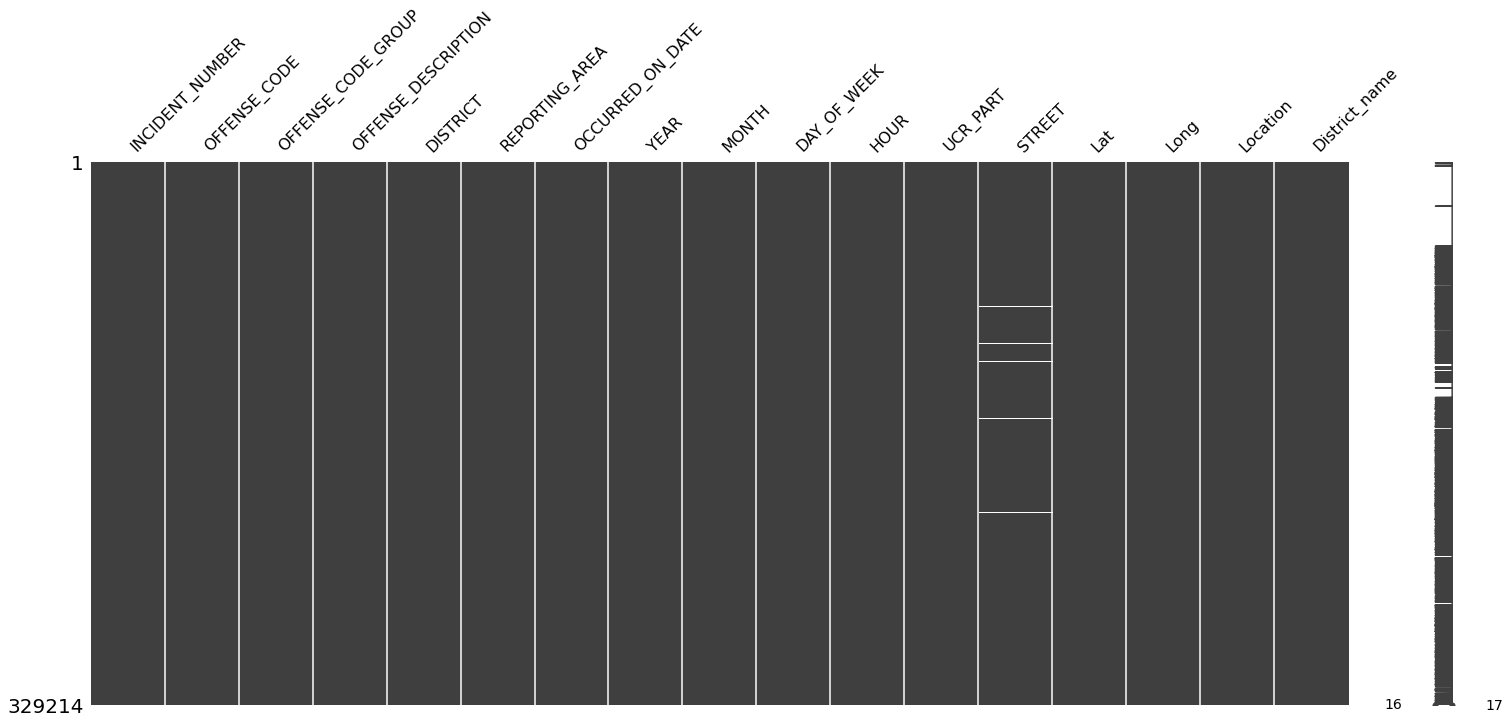

In [14]:
data = data.dropna(subset=['Lat','Long'])
msno.matrix(data)
plt.show()

## Transferring OCCURRED_ON_DATE to more useable columns

In [15]:
data['OCCURRED_ON_DATE'] = pd.to_datetime(data['OCCURRED_ON_DATE'])
data["DAY_OF_WEEK"] = pd.Categorical(data["DAY_OF_WEEK"], 
              categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
              ordered=True)
def create_features(df):
    df['dayofweek'] = df['OCCURRED_ON_DATE'].dt.dayofweek
    df['quarter'] = df['OCCURRED_ON_DATE'].dt.quarter
    df['dayofyear'] = df['OCCURRED_ON_DATE'].dt.dayofyear
    df['dayofmonth'] = df['OCCURRED_ON_DATE'].dt.day
    df['weekofyear'] = df['OCCURRED_ON_DATE'].dt.weekofyear
    
    X = df[['dayofweek','quarter','dayofyear',
            'dayofmonth','weekofyear']]
    return X
create_features(data).head()

# CategoricalDytpe
data.quarter    = data.quarter.astype(CategoricalDtype())
data.dayofweek    = data.dayofweek.astype(CategoricalDtype())
data.dayofyear    = data.dayofyear.astype(CategoricalDtype())
data.dayofmonth    = data.dayofmonth.astype(CategoricalDtype())

data.head()

<ipython-input-15-b23057678719>:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['OCCURRED_ON_DATE'].dt.weekofyear


,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,...,STREET,Lat,Long,Location,District_name,dayofweek,quarter,dayofyear,dayofmonth,weekofyear
0,I192068249,2647,Other,THREATS TO DO BODILY HARM,B2,280,2015-08-28 10:20:00,2015,8,Friday,...,WASHINGTON ST,42.330119,-71.084251,"(42.33011862, -71.08425106)",BOXBURY,4,3,240,28,35
1,I192061894,1106,Confidence Games,FRAUD - CREDIT CARD / ATM FRAUD,C11,356,2015-08-20 00:00:00,2015,8,Thursday,...,CHARLES ST,42.300605,-71.061268,"(42.30060543, -71.06126785)",DORCHESTER,3,3,232,20,34
2,I192038828,1107,Fraud,FRAUD - IMPERSONATION,A1,172,2015-11-02 12:24:00,2015,11,Monday,...,ALBANY ST,42.334288,-71.072395,"(42.33428841, -71.07239518)",DOWNTOWN,0,4,306,2,45
3,I192008877,1107,Fraud,FRAUD - IMPERSONATION,E18,525,2015-07-31 10:00:00,2015,7,Friday,...,WINGATE RD,42.237009,-71.129566,"(42.23700950, -71.12956606)",HYDE PARK,4,3,212,31,31
4,I182090828,1102,Fraud,FRAUD - FALSE PRETENSE / SCHEME,D4,159,2015-12-01 12:00:00,2015,12,Tuesday,...,UPTON ST,42.342432,-71.072258,"(42.34243222, -71.07225766)",SOUTH END,1,4,335,1,49


## Rename and reorder the column 

In [16]:
rename = {'OFFENSE_CODE_GROUP':'Group',
          'OFFENSE_DESCRIPTION':'Description',
          'DISTRICT':'District',
          'STREET':'Street',        
          'OCCURRED_ON_DATE':'Date',
          'YEAR':'Year',
          'MONTH':'Month',
          'DAY_OF_WEEK':'Day',
          'HOUR':'Hour'}

data.rename(index=str, columns=rename, inplace=True)


In [17]:
data = data[['INCIDENT_NUMBER', 'OFFENSE_CODE', 'Group', 'Description', 
        'Date', 'Year', 'Month', 'Day', 'Hour','dayofweek',
       'quarter', 'dayofyear', 'dayofmonth', 'weekofyear','District', 'District_name' ,'REPORTING_AREA', 'UCR_PART',
       'Street', 'Lat', 'Long', 'Location']]

data.head()

,INCIDENT_NUMBER,OFFENSE_CODE,Group,Description,Date,Year,Month,Day,Hour,dayofweek,...,dayofmonth,weekofyear,District,District_name,REPORTING_AREA,UCR_PART,Street,Lat,Long,Location
0,I192068249,2647,Other,THREATS TO DO BODILY HARM,2015-08-28 10:20:00,2015,8,Friday,10,4,...,28,35,B2,BOXBURY,280,Part Two,WASHINGTON ST,42.330119,-71.084251,"(42.33011862, -71.08425106)"
1,I192061894,1106,Confidence Games,FRAUD - CREDIT CARD / ATM FRAUD,2015-08-20 00:00:00,2015,8,Thursday,0,3,...,20,34,C11,DORCHESTER,356,Part Two,CHARLES ST,42.300605,-71.061268,"(42.30060543, -71.06126785)"
2,I192038828,1107,Fraud,FRAUD - IMPERSONATION,2015-11-02 12:24:00,2015,11,Monday,12,0,...,2,45,A1,DOWNTOWN,172,Part Two,ALBANY ST,42.334288,-71.072395,"(42.33428841, -71.07239518)"
3,I192008877,1107,Fraud,FRAUD - IMPERSONATION,2015-07-31 10:00:00,2015,7,Friday,10,4,...,31,31,E18,HYDE PARK,525,Part Two,WINGATE RD,42.237009,-71.129566,"(42.23700950, -71.12956606)"
4,I182090828,1102,Fraud,FRAUD - FALSE PRETENSE / SCHEME,2015-12-01 12:00:00,2015,12,Tuesday,12,1,...,1,49,D4,SOUTH END,159,Part Two,UPTON ST,42.342432,-71.072258,"(42.34243222, -71.07225766)"


In [18]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
OFFENSE_CODE,329214.0,2295.289110,1182.776062,111.000000,802.000000,2907.000000,3201.000000,3831.000000
Year,329214.0,2016.686757,1.041985,2015.000000,2016.000000,2017.000000,2018.000000,2018.000000
Month,329214.0,6.960381,3.331718,1.000000,4.000000,7.000000,10.000000,12.000000
Hour,329214.0,13.104968,6.284181,0.000000,9.000000,14.000000,18.000000,23.000000
weekofyear,329214.0,28.544658,14.576327,1.000000,17.000000,30.000000,41.000000,53.000000
Lat,329214.0,42.296993,1.046401,-1.000000,42.297555,42.325574,42.348624,42.395042
Long,329214.0,-71.042017,1.692250,-71.178674,-71.097223,-71.077565,-71.062563,-1.000000


## Visualizing crime count by District and UCR Categeory

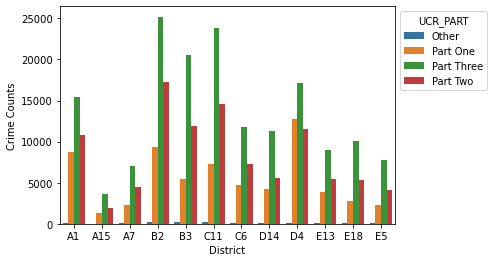

In [19]:
dis = data.groupby(by=["District","UCR_PART"]).size()
s = dis.to_frame()
s = s.reset_index()
s.columns = ["District","UCR_PART","Crime Counts"]
ax = sns.barplot(x ="District", y = 'Crime Counts', data = s, hue = "UCR_PART" )
plt.legend(title = 'UCR_PART', bbox_to_anchor = (1, 1))

## Crime count grouped by district and crime type

<AxesSubplot:xlabel='Group', ylabel='count'>

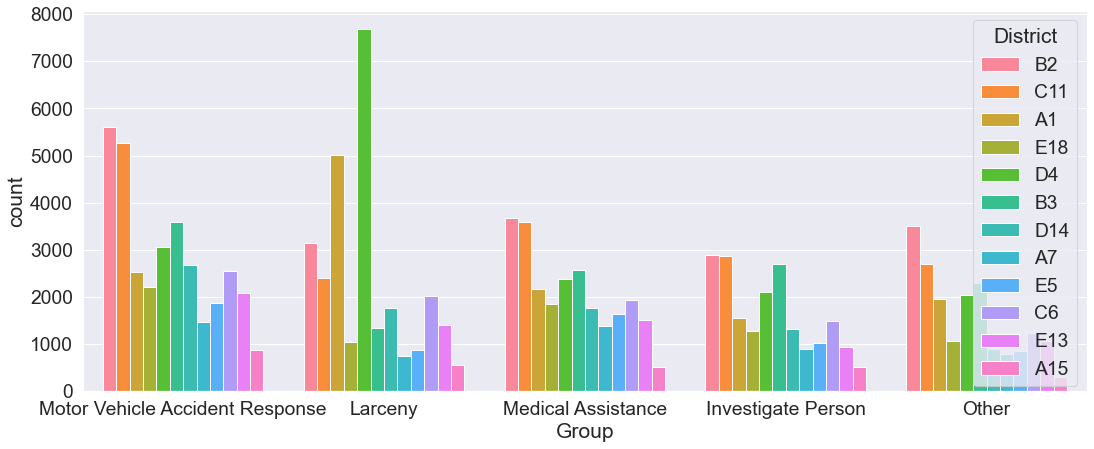

In [20]:
rcParams["figure.figsize"] = 18,7
sns.set(font_scale=1.75)
order = data['Group'].value_counts().head(5).index
sns.countplot(data = data, x='Group',hue='District', order = order,  saturation=2,linewidth=1)

## Analyzing crime with weekdays and hour

<AxesSubplot:xlabel='Hour', ylabel='dayofweek'>

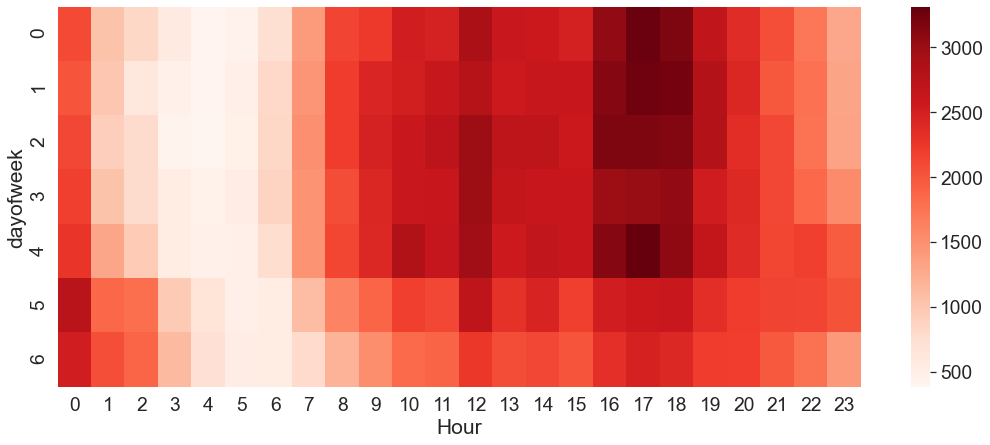

In [21]:
sns.heatmap(pd.pivot_table(data = data, index = "dayofweek", 
                              columns = "Hour", values = "INCIDENT_NUMBER", aggfunc = 'count'), 
                              cmap = 'Reds')

## Analyzing crime with Month

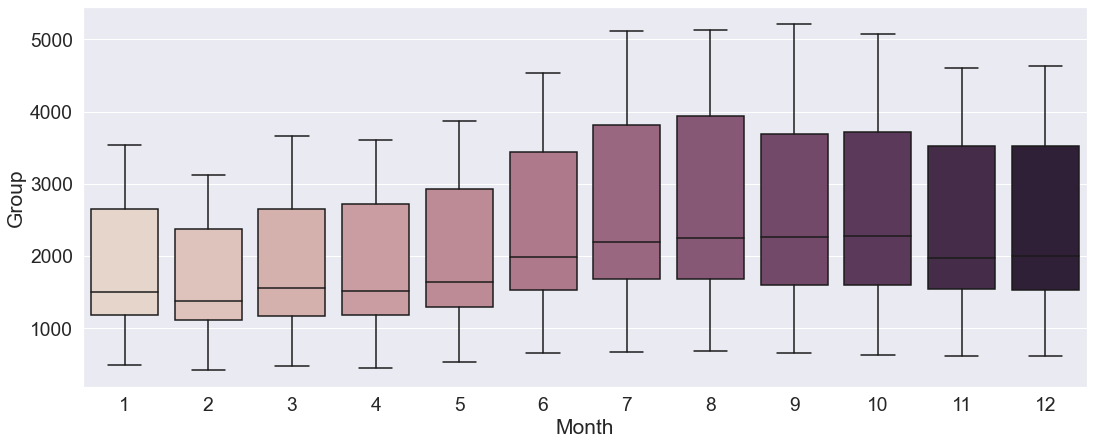

In [22]:
grouped = data.groupby(['Month','District']).count()
sns.boxplot(x ="Month", y = "Group", data = grouped.reset_index(), palette="ch:.102");

In [23]:
district = data['District_name'].unique()
latitude=[]
longitude=[]
coor = []
for i in range (len(district)):
    g = geocoder.arcgis('{}, Boston, MA'.format(district[i]))
    lat_lng_coords = g.latlng
    coor.append(lat_lng_coords)
    latitude.append(lat_lng_coords[0]) 
    longitude.append(lat_lng_coords[1]) 

district_coor = pd.DataFrame()
district_coor['district'] = district
district_coor['coor'] = coor
district_coor['latitude'] = latitude
district_coor['longitude'] = longitude

In [24]:
district_coor.head()

,district,coor,latitude,longitude
0,BOXBURY,"[42.330303515648225, -71.08946869163574]",42.330304,-71.089469
1,DORCHESTER,"[42.351354908126154, -71.05284849998098]",42.351355,-71.052848
2,DOWNTOWN,"[42.35829000000007, -71.05662999999998]",42.358290,-71.056630
3,HYDE PARK,"[42.27477303496225, -71.11989847471231]",42.274773,-71.119898
4,SOUTH END,"[42.34256000000005, -71.07357999999994]",42.342560,-71.073580


In [25]:
heatmap = folium.Map(location=[latitude[0], longitude[0]], zoom_start=13)
for index, row in district_coor.iterrows():
    folium.CircleMarker(
            row['coor'],
            radius=5,
            color='red',
            fill=True,
            popup = row['district'],
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(heatmap) 
heatmap

In [ ]:
for index, row in data.iterrows():
    folium.CircleMarker([row['Lat'],row['Long']],
                        radius=2,
                        popup = folium.Popup(row['Street']),
                        fill_color="#3db7e4" # divvy color
                       ).add_to(heatmap)
heatmap

In [ ]:
heat = data[['Lat', 'Long']].as_matrix()
heatmap.add_children(plugins.HeatMap(heat,radius=13))
heatmap

In [ ]:
import json
import urllib.request
url = 'https://data.boston.gov/api/3/action/datastore_search?resource_id=792031bf-b9bb-467c-b118-fe795befdf00'  
fileobj = urllib.request.urlopen(url)
response_dict = json.loads(fileobj.read())
print(response_dict)

In [ ]:
CLIENT_ID = 'AQ4P5KPELSSWLOEVTEC0ET4FNEVSJJATZC1NUQ13YFMY11W1' # your Foursquare ID
CLIENT_SECRET = 'BMGVJICF0ZI0OAXWYEQRAU3DD4S503UH3VEG0BCKAWKIOWMF' # your Foursquare Secret
ACCESS_TOKEN = '1JVCUVC4B0EDL4JMLOSQ2INS35E3R2VYMEWS55U4UZW0FBMV' # your FourSquare Access Token
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)